# Auto-encodeur Convolutif et Réduction de Dimension


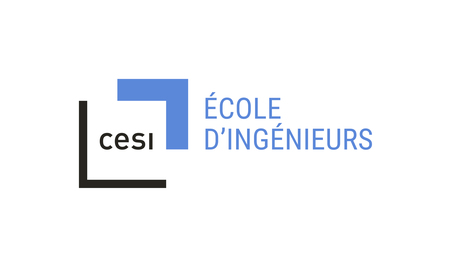

Ce workshop aborde une nouvelle architecture de réseaux de neurones, les auto-encodeurs. Cette architecture est constituée de deux parties, l'encodeur et le décodeur. Elle permet de construire une nouvelle représentation d’un jeu de données plus compacte, avec moins de descripteurs, ce qui permet de réduire la dimensionnalité du jeu de données. Dans ce workshop, nous allons découvrir le fonctionnement des auto-encodeurs sur un problème de classification.

# Importation et Chargement du Dataset 

Le Dataset utilisé dans ce Workshop est le célèbre jeu de données MNIST (chiffres manuscrits). Nous utilisons la version CSV de ce jeu de données disponible ici : https://pjreddie.com/projects/mnist-in-csv/

Nous ne conserverons que le fichier mnist_test.csv, contenant 10 000 images en niveaux de gris de dimension 28 x 28.

In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [129]:
df = pd.read_csv(r'mnist_test.csv', header=None)
df['pixels'] = df.index.map(lambda x: np.array(df.iloc[x][1:]))
dropcols = df.columns[(df.columns != 0) * (df.columns != 'pixels')]
df.drop(dropcols, axis=1, inplace=True)
df.columns = ['label','pixels']
print(df.shape)

(10000, 2)


In [130]:
df.head()

,label,pixels
0,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Nous pouvons commencer par afficher un exemple d'une image du dataset MNIST (Niveaux de gris ==> Image)

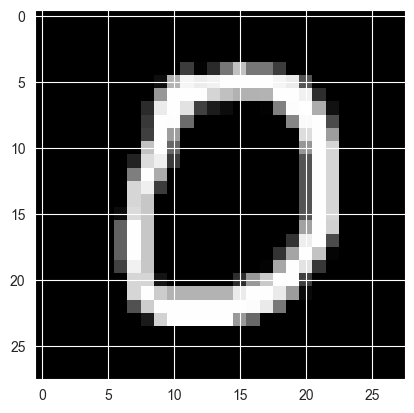

In [131]:
fig = plt.imshow(df['pixels'][10].reshape(28,28), cmap='gray')

# Réduction de Dimension

Dans cette section, nous allons réfléchir à la manière de distinguer les caractéristiques de différents chiffres manuscrits, en partant uniquement des valeurs brutes des pixels comme caractéristiques.

Considérons 3 chiffres. Gardez-les tels quels pour le moment, vous aurez le temps à la fin de jouer avec ces paramètres.

In [132]:
## Chiffres considérés ##
labels = [1,6,8]
colors = ['red', 'blue', 'green']

X = np.array([df['pixels'][i] for i in df.index if df['label'][i] in labels])
y = np.array([df['label'][i] for i in df.index if df['label'][i] in labels])

In [133]:
## Print des dimensions des données

print('X shape: '+str(X.shape))
print('y shape: '+str(y.shape))

X shape: (3067, 784)
y shape: (3067,)


Nous avons 28 x 28 = 784 caractéristiques. Il s'agit d'une dimension élevée (~ même ordre de grandeur que le nombre de points).

Dans ce cas, on ne peut pas s'appuyer sur une analyse univariée : il est bien évident que la valeur d'un pixel donné sur l'image ne déterminera pas, à elle seule le nombre qui est écrit (la classe). Il faut étudier la relation entre les valeurs des pixels : voyons comment les méthodes de réduction de la dimensionnalité peuvent nous aider à distinguer le bruit, la corrélation et les modèles d'information !

### Analyse en Composantes Principales (ACP) : Approche Linéaire

Comme vous l'avez-vu l'année précédente dans le bloc IA (partie Pipeline ML), nous pouvons utiliser l'ACP (Analyse en Composante Principale) afin d'analyser et de réduire la dimension de l'image. Pour plus de détails sur l'ACP, vous pouvez consulter les liens suivants:
* https://ocw.mit.edu/courses/mathematics/18-650-statistics-for-applications-fall-2016/lecture-videos/lecture-19-video/
* https://ocw.mit.edu/courses/mathematics/18-650-statistics-for-applications-fall-2016/lecture-slides/MIT18_650F16_PCA.pdf
* https://ocw.mit.edu/courses/brain-and-cognitive-sciences/9-641j-introduction-to-neural-networks-spring-2005/lecture-notes/lec18_pca.pdf

In [134]:
from sklearn.decomposition import PCA

In [135]:
## Calcul de l'ACP
pca = PCA(n_components=3)
XPCA = pca.fit_transform(X)


In [136]:
XPCA.shape

(3067, 3)

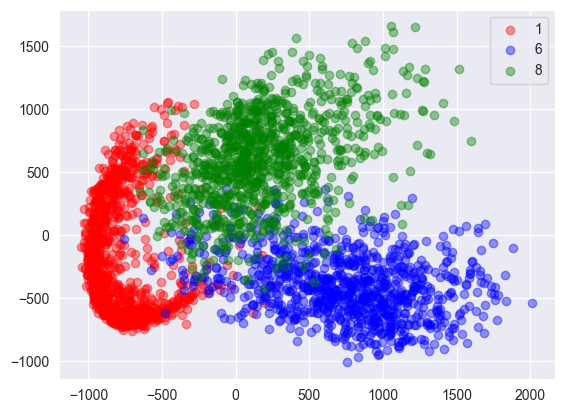

In [137]:
## Sélection d'axes pour la visualisation
component_x = 1
component_y = 2

## Plotting
fig, ax = plt.subplots()
for i in range(len(labels)):
    ax.scatter(XPCA[y == labels[i],component_x-1],
               XPCA[y == labels[i],component_y-1],
               c=colors[i], label=labels[i], alpha=0.4)

l = ax.legend()

Il est aussi possible d'afficher les données en 3D pour afficher une dimension supplémentaire de notre vecteur produit par le PCA.

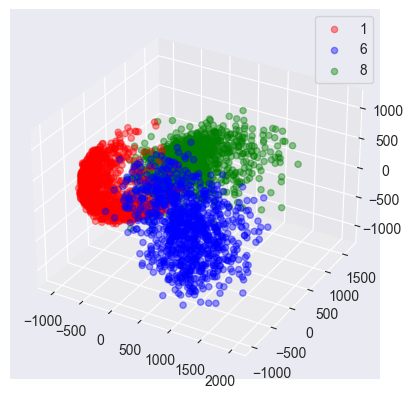

In [138]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
## Sélection d'axes pour la visualisation
component_x = 1
component_y = 2
component_z = 3

## Plotting
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for i in range(len(labels)):
    ax.scatter(XPCA[y == labels[i],  component_x-1],
               XPCA[y == labels[i],component_y-1],
               XPCA[y == labels[i],component_z-1],
               c=colors[i], label=labels[i], alpha=0.4)

l = ax.legend()

Essayez de visualiser différents axes et trouvez ceux qui permettent (ou non) de distinguer les classes.

### T-distributed Stochastic Neighbor Embedding : Approche non-Linéaire

La plupart des ensembles de données présentent une relation non linéaire entre les caractéristiques et les points de données dans un espace à haute dimension. Par conséquent, nous voulons créer un encodage à faible dimension,pour ces données,qui préserve la relation entre les différents points dans l'espace d'origine. Pour cela, l'algorithme TSNE (T-distributed Stochastic Neighbor Embedding) est une approche probabiliste consistant à placer des objets (ex.: images), décrits par des vecteurs à haute dimension (ex. valeurs de niveaux de gris), dans un espace à basse dimension de manière à préserver l'identité des voisins. Pour plus de détails sur cet algorithme, vous pouvez consulter les ressources suivantes: 
* http://www.cs.columbia.edu/~verma/classes/uml/lec/uml_lec8_tsne.pdf
* https://www.cs.toronto.edu/~jlucas/teaching/csc411/lectures/lec13_handout.pdf
    

In [139]:
from sklearn.manifold import TSNE

In [140]:
## Calcul du t-SNE 2D projection

## Paramètres avec une réelle influence sur l'accuracy
perplexity = 30
learning_rate = 200
n_iter = 1000

tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
XTSNE = tsne.fit_transform(X)


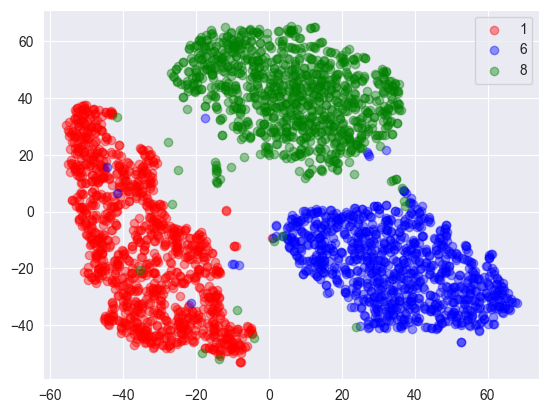

In [141]:
## Plotting
fig, ax = plt.subplots()
for i in range(len(labels)):
    ax.scatter(XTSNE[y == labels[i],0],
               XTSNE[y == labels[i],1],
               c=colors[i], label=labels[i], alpha=0.4)
l = ax.legend()

# Impact sur la performance du modèle supervisé

Dans cette section, nous considérons un modèle d'apprentissage automatique supervisé pour prédire la classe d'une image (à quel chiffre elle correspond). Nous partons du principe que la tâche de classification, ainsi que les algorithmes permettant de la résoudre sont des compétences acquises dans le Bloc IA. Pour plus d'informations sur cette partie, merci de vous référer aux partie Classification et Pipeline ML, vues en 4ème année.


Nous allons étudier l'impact de la réduction de la dimensionnalité sur 3 classifieurs qui ont des mécanismes différents :
* Naive Bayes Classifier (NB)
* SVM (SVM)
* Random Forest Classifier (RF)

Nous pouvons leur donner comme caractéristiques 3 entrées différentes :

* Toutes les valeurs des pixels (brutes)
* Les n premières composantes de l'ACP (10 par exemple)
* Les 2 dimensions de la projection t-SNE (tsne)



In [142]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [143]:
def fit_my_model(model, features, test_size):
    
    ## Construction des ensembles train et test à partir de l'ensemble des features
    if features == 'raw':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    elif features == 'tsne':
        X_train, X_test, y_train, y_test = train_test_split(XTSNE, y, test_size=test_size, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(XPCA[:,:features], y, test_size=test_size, random_state=42)

    print("Training samples: "+str(X_train.shape[0]))
    print("Testing samples: "+str(X_test.shape[0]))
    print("Number of features: "+str(X_train.shape[1]))
    
    ## Fit model
    if model == 'nb':
        clf = GaussianNB()
    elif model == 'svm':
        clf = SVC(gamma='auto')
    elif model == 'rf':
        clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None, max_features=np.min([10, X_train.shape[1]]))

    clf.fit(X_train, y_train)
    
    ## Impression des scores
    learningScore = clf.score(X_train, y_train)
    generalizationScore = clf.score(X_test, y_test)
    print('Learning score: '+str(learningScore))
    print('Generalization score: '+str(generalizationScore))
    
    return generalizationScore

Maintenant, on choisit le modèle de classification et la méthode de réduction de dimension. La réduction va être l'entrée du modèle de classification.

In [144]:
model = 'rf' ## svm, nb, rf
features = 'raw' ## raw, tsne, ou entier correspondant au n premières composantes de l'ACP
test_size = 0.2
score = fit_my_model(model, features, test_size)

Training samples: 2453
Testing samples: 614
Number of features: 784
Learning score: 1.0
Generalization score: 0.990228013029316


Testons toutes les configurations et construisons un tableau de résultats avec les scores des tests, pour vous aider à répondre à cette question.

In [145]:
comparison_table = pd.DataFrame(columns = ['raw', 'pca', 'tsne'], index=['svm', 'nb', 'rf'])
for f in comparison_table.columns:
    for m in comparison_table.index:
        print("\n"+f + ' - ' + m)
        comparison_table.loc[m,f] = fit_my_model(m, f if f!='pca' else 10, 0.2)


raw - svm
Training samples: 2453
Testing samples: 614
Number of features: 784
Learning score: 1.0
Generalization score: 0.34201954397394135

raw - nb
Training samples: 2453
Testing samples: 614
Number of features: 784
Learning score: 0.9196901752955564
Generalization score: 0.8941368078175895

raw - rf
Training samples: 2453
Testing samples: 614
Number of features: 784
Learning score: 1.0
Generalization score: 0.990228013029316

pca - svm
Training samples: 2453
Testing samples: 614
Number of features: 3
Learning score: 1.0
Generalization score: 0.34201954397394135

pca - nb
Training samples: 2453
Testing samples: 614
Number of features: 3
Learning score: 0.9437423562984101
Generalization score: 0.9429967426710097

pca - rf
Training samples: 2453
Testing samples: 614
Number of features: 3
Learning score: 1.0
Generalization score: 0.9397394136807817

tsne - svm
Training samples: 2453
Testing samples: 614
Number of features: 2
Learning score: 0.9975540154912352
Generalization score: 0.99

Visualisons le résultat sous forme de carte de chaleur.

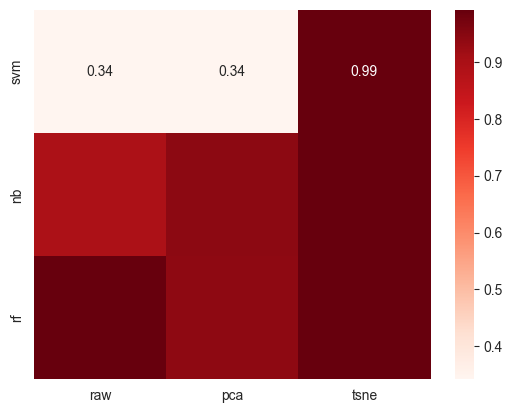

In [146]:
## Heatmap with summarized results
fig = sns.heatmap(comparison_table.astype('float'), annot=True, cmap='Reds')

Quel est l'effet de la réduction de la dimensionnalité sur les 3 classifieurs ? Essayez d'expliquer pourquoi avec votre intuition...
<em>À COMPLÉTER</em>


Ces exemples ne concernent que les classifieurs supervisés. Pouvez-vous imaginer l'impact sur d'autres tâches : régression, clustering, détection d'anomalies... ?
<em>À COMPLÉTER</em>


# Autoencodeurs 

Dans cette section, nous allons construire pas à pas une architecture d'autoencodeur, l'entraîner et l'évaluer sur les données MNIST. Il s'agira d'abord d'un auto-encodeur standard entièrement connecté, puis d'un auto-codeur variationnel dans la section suivante.

Pour préparer ce travail, importons les bibliothèques appropriées et utilisons le jeu de données MNIST complet de Keras, car les réseaux neuronaux auront besoin de plus de données pour l'entraînement.

In [147]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [148]:
import numpy as np

In [149]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = np.array([x.flatten() for x in X_train]).astype("float32") / 255.
X_test = np.array([x.flatten() for x in X_test]).astype("float32") / 255.
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


Il est d'usage de normaliser les données d'entrées d'un réseau de neurones entre 0 et 1, car cela accélère l'entrainement du réseau.

### Autoencodeur Standard

Dans cette première partie, nous implémentons un auto-encodeur standard (entièrement connecté). Commençons par les architectures séparées pour l'encodeur et le décodeur. Faites attention à l'activation de la couche finale ! 

Nous allons, dans cette section, construire un Encodeur comprenant:
* Une couche des données d'entrée de 28x28, 
* Une couche cachée Fully connected de 200 unités et,
* Une sortie de 15 unités (vous pouvez changer le chiffre), qui représente la dimension de l'espace latent

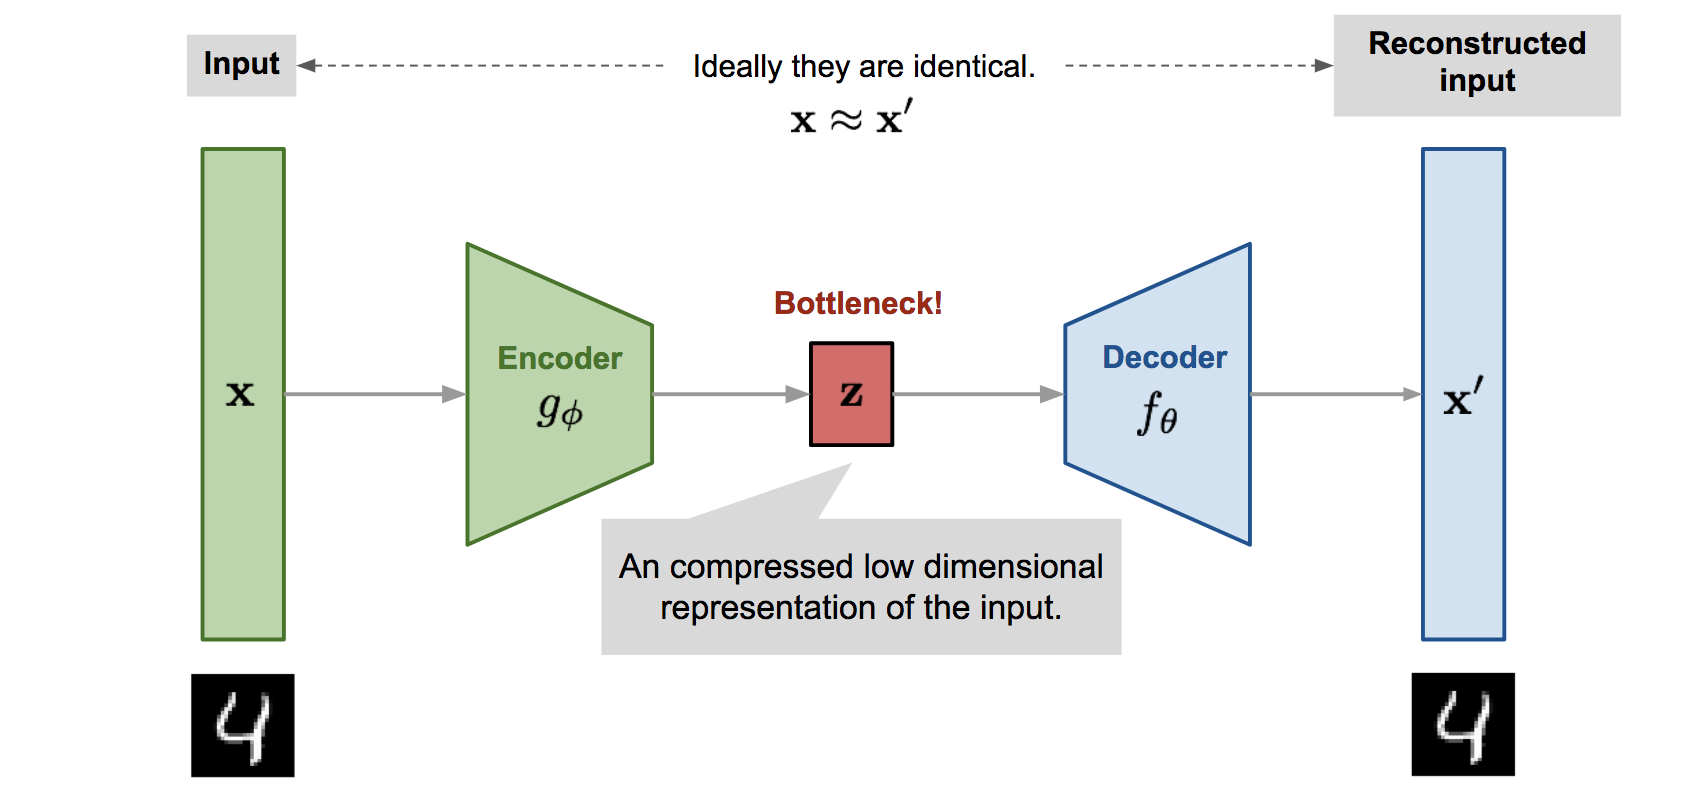

In [150]:
latent_space_dim = 15

# Architecture de l'Encodeur
encoder_inputs = keras.Input(shape=(28*28,))
hidden1 = layers.Dense(200, activation="relu")(encoder_inputs)
latent_space = layers.Dense(latent_space_dim)(hidden1)

encoder = keras.Model(encoder_inputs, latent_space, name="encoder")


On peut même afficher et sauvegarder la structure du modèle :

In [151]:
from keras.utils import plot_model
plot_model(encoder, to_file='encodersimple.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Occupons-nous maintenant du décodeur. Appliquez le même principe, cette cellule est symétrique à la précédente. La seule différence est la dernière couche, où la fonction d'activation va utiliser sigmoïde.

In [152]:
# Architecture du Décodeur
decoder_inputs = keras.Input(shape=(latent_space_dim,))
hidden2 = layers.Dense(200, activation="relu")(decoder_inputs)
decoder_outputs = layers.Dense(28*28, activation="sigmoid")(hidden2)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

Là aussi on affiche et sauvegarde le modèle.

In [153]:
from keras.utils import plot_model
plot_model(decoder, to_file='decodersimple.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Maintenant, nous allons combiner les deux architecture (Encodeur, Décodeur) pour construire l'AutoEncodeur (AE) complet. Pour rappel, la sortie de l'encodeur est l'entrée du décodeur.

In [154]:
# Combinaison des deux Architecture (Enc,Dec)
outputs = decoder(latent_space)
autoencoder = keras.Model(encoder_inputs, outputs, name="autoencoder")


In [155]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_9 (Dense)             (None, 200)               157000    
                                                                 
 dense_10 (Dense)            (None, 15)                3015      
                                                                 
 decoder (Functional)        (None, 784)               160784    
                                                                 
Total params: 320799 (1.22 MB)
Trainable params: 320799 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Remarque: il est possible de créer une classe Autoencoder pour permettre d'avoir une architecture réutilisable.  
Voir le lien https://www.tensorflow.org/tutorials/generative/autoencoder#first_example_basic_autoencoder

Nous devons maintenant définir la fonction de perte (ou Loss) pour l'apprentissage (ou Training). S'agissant d'une tâche de classification, et comme vous l'avez vue l'année dernière (Bloc IA - Classification), dans le cas des images MNIST, nous pouvons utiliser une entropie croisée binaire par pixel, additionnée sur la totalité de l'image. C'est-à-dire, nous pouvons utiliser la fonction d'entropie croisée binaire, afin d'estimer l'erreur de reconstruction sur chaque pixel de l'image. Au total, nous aurons 784 valeurs d'entropie croisée pour lesquels nous allons calculer une moyenne. Cette moyenne représentra l'erreur totale. Nous pouvons également utiliser une erreur quadratique moyenne, mais laissons cela comme un exercice.

In [156]:
# Définition de la fonction de perte (Loss Fct)
reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, outputs) * 784

autoencoder_loss = K.mean(reconstruction_loss)

Il ne reste plus qu'à ajouter la fonction de perte dans l'auto-encodeur, et compiler le modèle.

In [157]:
# Compiler le modèle
autoencoder.add_loss(autoencoder_loss)
autoencoder.compile(optimizer="adam")

VOyons maintenant ce que ça donne. Entrainons le modèle sur 30 epochs, en divisant le dataset en batch de 128 :

In [158]:
# Exécution du modèle
history = autoencoder.fit(X_train, X_train,
            epochs=30,
            batch_size=128,
            shuffle=True,
            validation_data=(X_test, X_test))

Epoch 1/30
469/469 [==============================] - 3s 5ms/step - loss: 137.6784 - val_loss: 97.8029
Epoch 2/30
469/469 [==============================] - 2s 5ms/step - loss: 93.6334 - val_loss: 88.7868
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 87.7555 - val_loss: 85.0843
Epoch 4/30
469/469 [==============================] - 2s 4ms/step - loss: 84.7868 - val_loss: 82.7779
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 82.8139 - val_loss: 81.0483
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 81.2894 - val_loss: 79.8384
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 80.1320 - val_loss: 78.9107
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - loss: 79.2138 - val_loss: 78.2335
Epoch 9/30
469/469 [==============================] - 2s 4ms/step - loss: 78.4834 - val_loss: 77.5844
Epoch 10/30
469/469 [==============================] - 2s 4ms/step - loss: 77.846

Nous allons sauvegarder les poids pour un usage ultérieur.

In [159]:
autoencoder.save_weights('./autoencoder-77.5.h5')


Afin d'avoir une idée sur les performances du modèle développé, nous allons visualiser les valeurs de la fonction Loss.

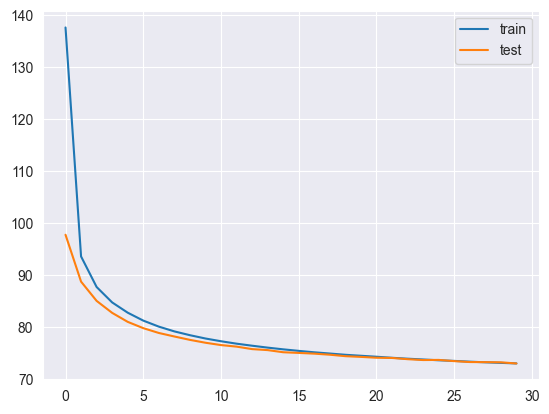

In [160]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

Nous semblons obtenir un modèle assez raisonnable ! Visualisons la qualité des images reconstruites.

1/1 [==============================] - 0s 17ms/step


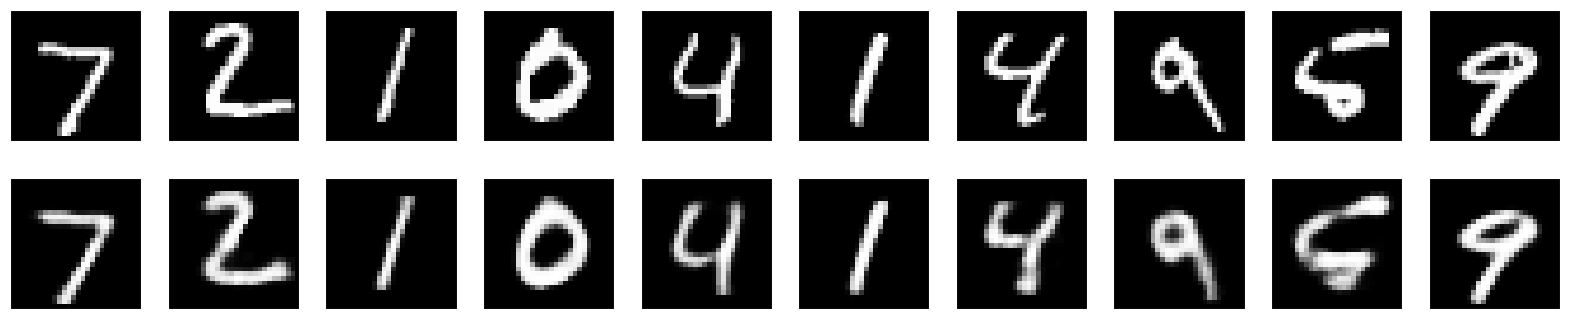

In [161]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    encoded_img = encoder.predict(np.array([X_test[i]]).reshape(1,784))
    decoded_img = decoder.predict(encoded_img).reshape(28, 28)
    plt.imshow(decoded_img, cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Nous pouvons voir que certains détails sont perdus, mais les formes globales sont correctement reconstruites.  
 
>Le résultat de ce processus est que l'auto-encodeur reproduit en sortie la même image qu'il reçoit en entrée, tout en passant par un **espace latent** de plus petite dimension: ici 15.
>Cela semble peu utile, cependant, comme nous avons séparé l'auto-encodeur en encodeur d'une part et décodeur d'autre part, nous pouvons les utiliser de manière distincte.  
>Par exemple, en ne conservant que l'encodeur, il est possible de représenter une image d'un chiffre composée de 784 pixels avec un vecteur de 15 valeurs.

In [162]:
x_test_latent = encoder.predict(X_test)

313/313 [==============================] - 0s 865us/step


Nous venons de concevoir un modèle "Générative" qu'on peux utiliser dans plusieurs applications, par exemple:
* Réduction de dimension: comme évoqué précédemment, nous pouvons utiliser la fonction d'Encodage (partie Encodeur du réseau) afin de réduire la dimension des données en entrée. Par exemple, une image est donnée en entrée à l'Encodeur, qui produit, selon l'exemple précédent, un vecteur contenant 15 valeurs (comprisent entre 0 et 1)
* Génération de nouvelles images: nous pouvons aussi utiliser la partie Décodeur du réseau et l'alimenter avec des vecteurs (15 valeurs dans l'exemple précédent) génrées d'une manière aléatoire. En faisant cela, le Décodeur génèrera de nouvelles images non-contenues dans le Dataset. 
* Réduction de bruit (Débruitage): nous pouvons aussi entraîner l'AutoEncodeur avec des images bruitées en entrée et d'autres débruitées en sortie, ce qui nous permet de concevoir un AutoEncodeur de débruitage (Denoising AutoEncoder). Ceci est représenté dans l'image suivante:
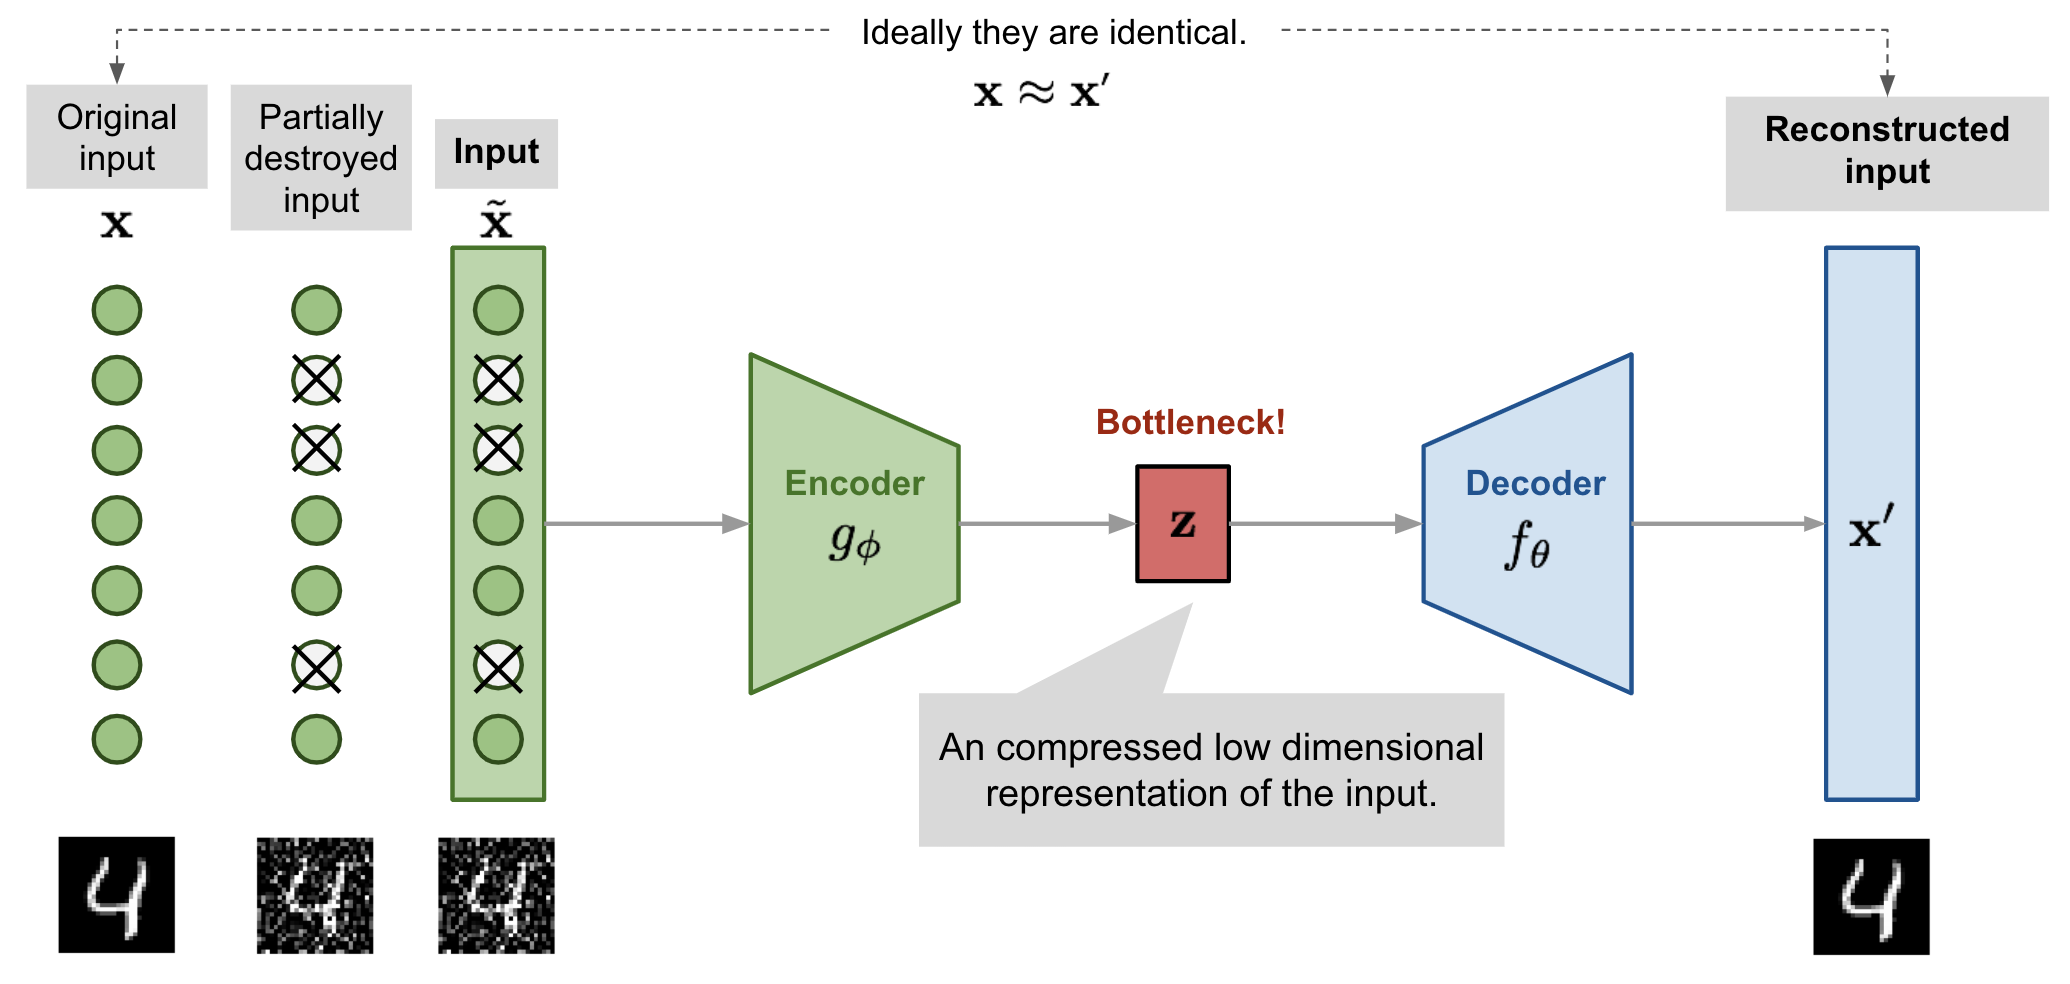
D'ailleurs, vous verrez dans le détail cette application dès le WOrkshop suivant !

Enfin, et pour conclure sur les AE, ces réseau sont très sensible au phénomène de sur-apprentissage. Afin d'éviter ce phénomène, une version améliorée de ce concept est utilisée de nos jours sous le nom: "AutoEncodeur Variationnel". Le concept génral reste le même, on crée un Encodeur et un Décodeur. Par contre, au ieu d'utiliser des fonctions scalaire, nous allons définir des fonctions de probabilités pour encoder et décoder l'image. 

### Autoencodeur Variationnel

Dans cette deuxième partie, nous allons implémenter un autoencodeur variationnel. Commençons par définir la couche spécifique que nous utiliserons pour échantillonner les valeurs de la distribution gaussienne définie par les moyennes et les écarts types de l'espace latent (z_mean, z_logvar).
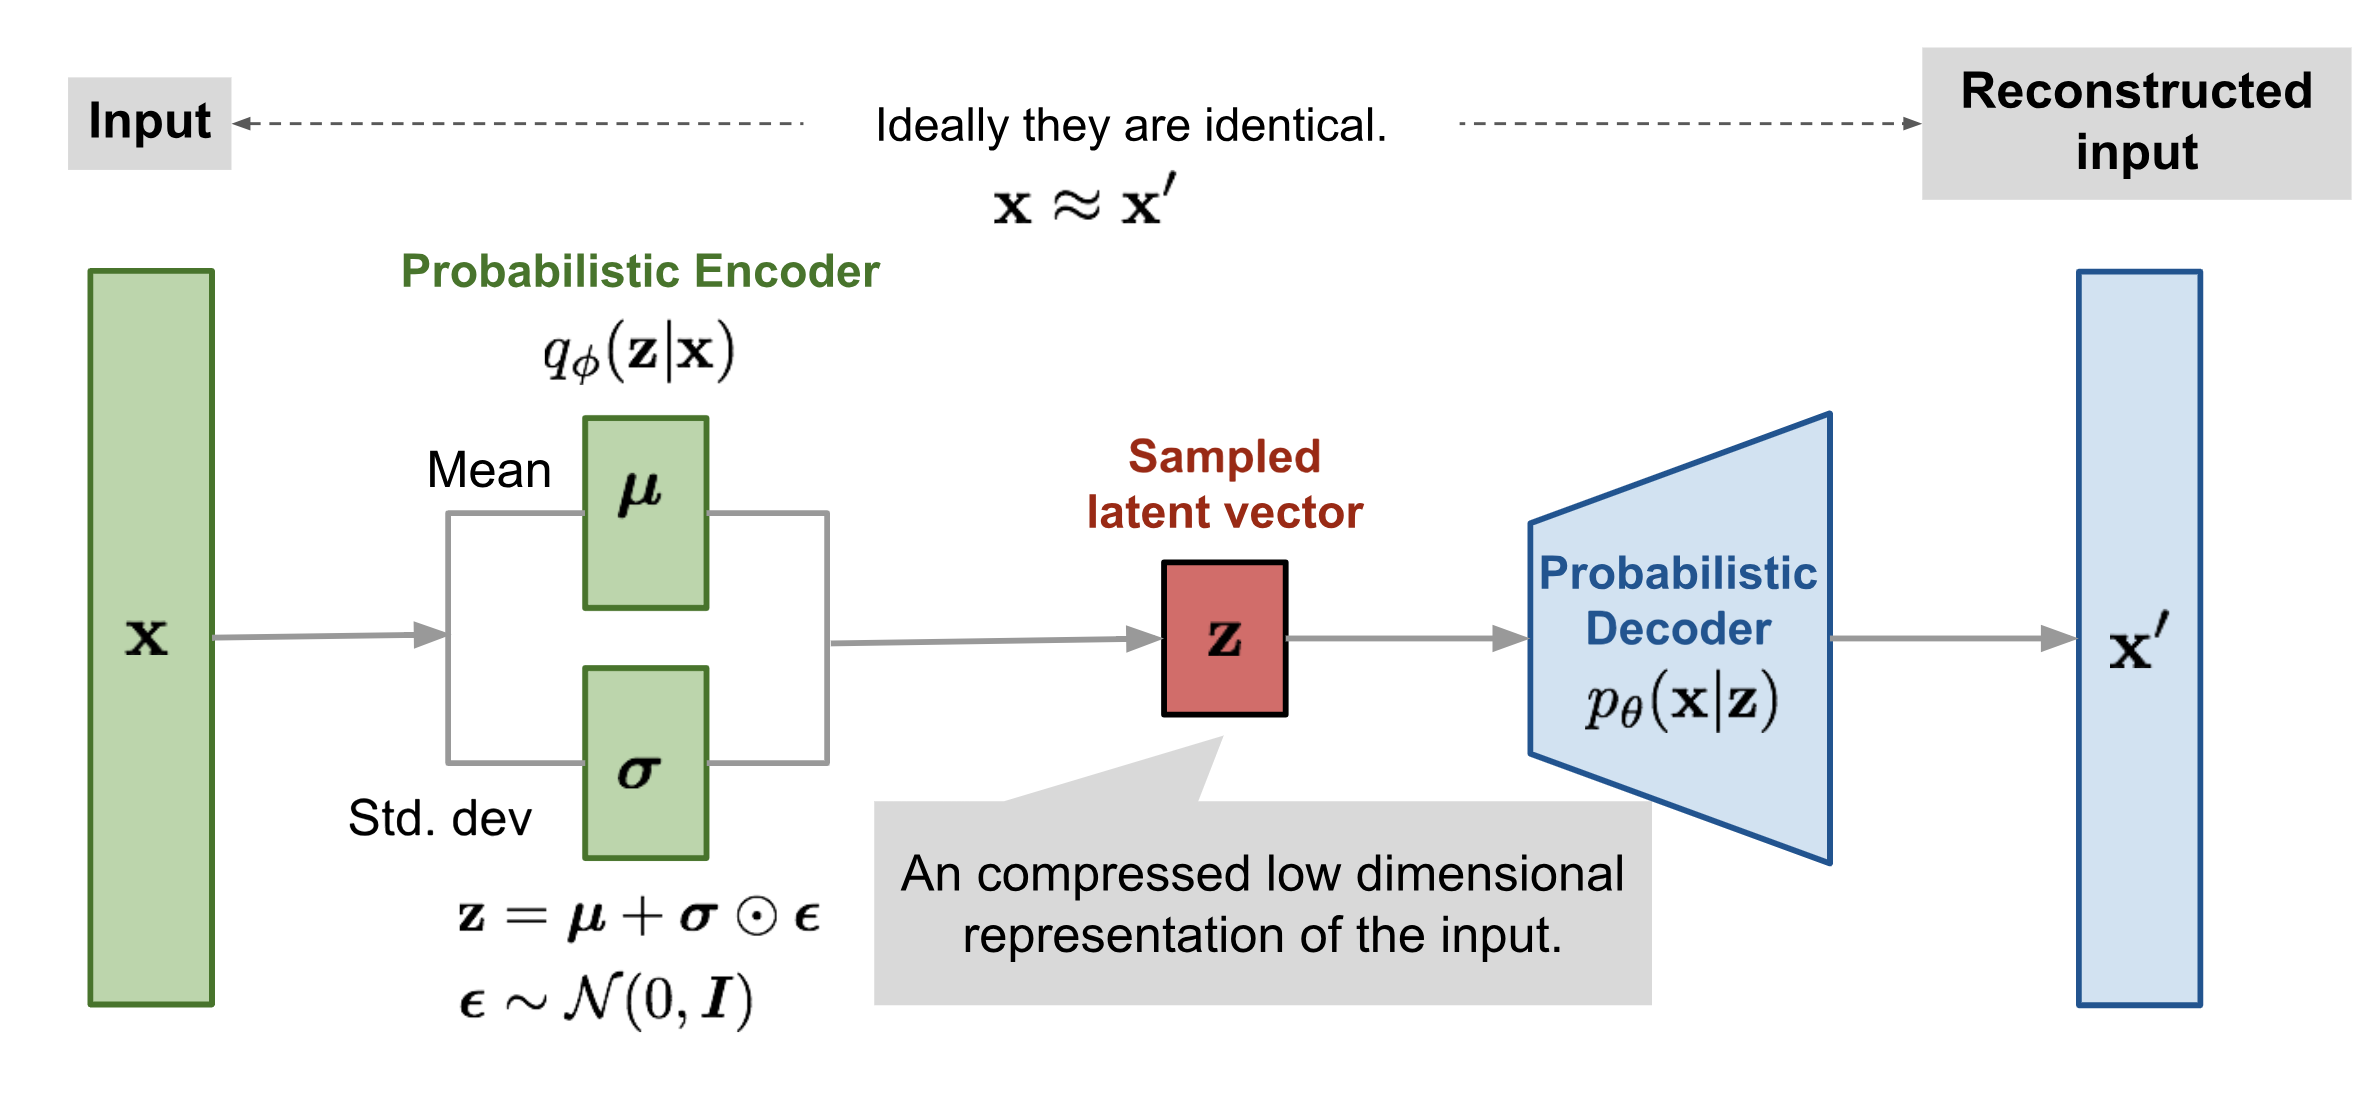

In [163]:
# Coding the specific sampling layer as a Keras Layer object
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_logvar = inputs

        nbatch = K.shape(z_mean)[0]
        ndim = K.shape(z_mean)[1]

        std = K.exp(z_logvar)
        eps = K.random_normal(shape=(nbatch,ndim), mean=0., stddev=0.1)
        
        z = z_mean + eps * std

        return z


Ecrivons maintenant les architectures séparées de l'encodeur et du décodeur. Attention, pas de fonction d'activation pour le calcul de la moyenne et de la logvar...

In [207]:
encoder_inputs = keras.Input(shape=(784,))
hidden1 = layers.Dense(200, activation="relu")(encoder_inputs)

z_mean = layers.Dense(10)(hidden1)
z_logvar = layers.Dense(10)(hidden1)

# Sampling
z = Sampling()([z_mean, z_logvar])

encoder = keras.Model(encoder_inputs, z, name="encoder")


In [165]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [208]:
# Decoder architecture
decoder_inputs = keras.Input(shape=(10,))
decoder_hidden = layers.Dense(200, activation="relu")(decoder_inputs)
decoder_outputs = layers.Dense(784, activation="sigmoid")(decoder_hidden)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

In [209]:
from keras.utils import plot_model
plot_model(decoder, to_file='decoder.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Maintenant, nous les combinons pour construire le codeur automatique complet.

In [210]:
# Combining architectures
outputs = decoder(z)
vae = keras.Model(encoder_inputs, outputs, name="vae")

In [211]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_18 (Dense)            (None, 200)                  157000    ['input_9[0][0]']             
                                                                                                  
 dense_19 (Dense)            (None, 10)                   2010      ['dense_18[0][0]']            
                                                                                                  
 dense_20 (Dense)            (None, 10)                   2010      ['dense_18[0][0]']            
                                                                                                

Nous devons maintenant définir la fonction de perte pour l'apprentissage. Comme perte de reconstruction, nous pouvons toujours utiliser l'entropie croisée binaire par pixel, additionnée sur l'image. Dans le cas de VAE, il existe un terme supplémentaire à la perte : la [divergence de Kullback-Leibler](https://fr.wikipedia.org/wiki/Divergence_de_Kullback-Leibler). Ecrivez ce nouveau terme, en utilisant les fonctions backend de Keras : K.square, K.exp, K.sum...  


In [213]:
# Loss function definition
reconstruction_loss = keras.losses.binary_crossentropy(encoder_inputs, outputs) * 784

#kl
kl_loss = -0.5 * K.sum(1 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=1)

vae_loss = K.sum(reconstruction_loss + kl_loss)


In [214]:
# Compiling the model
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [215]:
# Fitting the model
history = vae.fit(X_train, X_train,
                  epochs=30,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(X_test, X_test))

Epoch 1/30
469/469 [==============================] - 4s 5ms/step - loss: 20697.0664 - val_loss: 15301.6934
Epoch 2/30
469/469 [==============================] - 2s 5ms/step - loss: 14973.3057 - val_loss: 14248.8389
Epoch 3/30
469/469 [==============================] - 2s 5ms/step - loss: 14169.1904 - val_loss: 13589.5869
Epoch 4/30
469/469 [==============================] - 2s 5ms/step - loss: 13680.0811 - val_loss: 13228.6426
Epoch 5/30
469/469 [==============================] - 2s 5ms/step - loss: 13345.6123 - val_loss: 12949.9531
Epoch 6/30
469/469 [==============================] - 2s 5ms/step - loss: 13110.2061 - val_loss: 12737.7188
Epoch 7/30
469/469 [==============================] - 2s 5ms/step - loss: 12919.1982 - val_loss: 12585.8662
Epoch 8/30
469/469 [==============================] - 2s 5ms/step - loss: 12760.2002 - val_loss: 12444.0713
Epoch 9/30
469/469 [==============================] - 2s 5ms/step - loss: 12626.9580 - val_loss: 12321.8398
Epoch 10/30
469/469 [=======

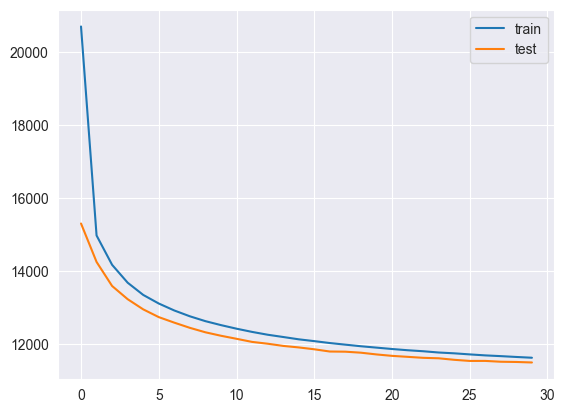

In [216]:
# Visualizing the training and validation losses
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

Nous semblons obtenir un processus de formation assez raisonnable ! Visualisons la qualité des images reconstruites.

1/1 [==============================] - 0s 16ms/step


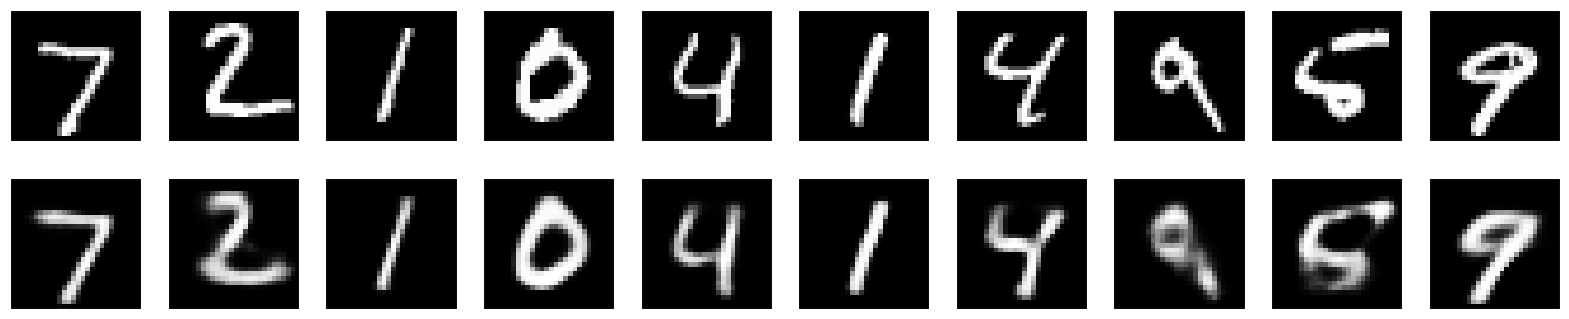

In [217]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    encoded_img = encoder.predict(np.array([X_test[i]]).reshape(1,784))
    decoded_img = decoder.predict(encoded_img).reshape(28, 28)
    plt.imshow(decoded_img, cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Nous pouvons voir que certains détails sont perdus, mais que les formes globales sont correctement reconstruites.

Comme un VAE utilise un modèle génératif, nous pouvons utiliser le décodeur pour construire de fausses images, et nous pouvons voir que l'espace latent est continu ! Échantillonnons quelques images aléatoires dans une plage donnée de valeurs de l'espace latent.

1/1 [==============================] - 0s 16ms/step


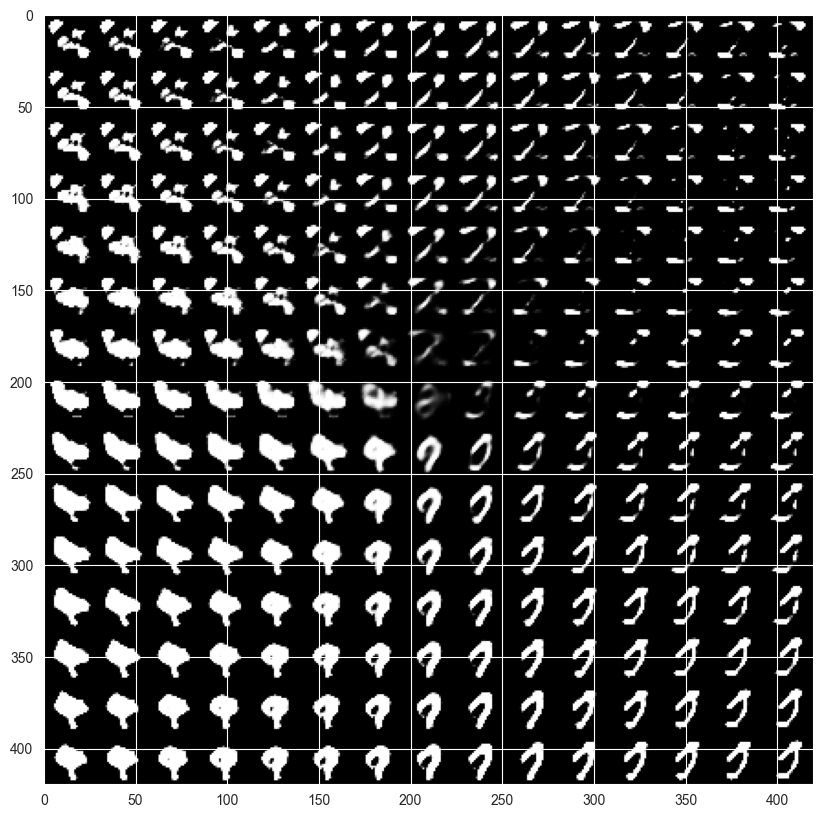

In [218]:
n = 15  # figure with 15x15 generated images
figure = np.zeros((28 * n, 28 * n))

# We sample n images within [-15, 15] standard deviations, around 0 mean
# Vincent:Comment définir les valeurs pour générer les images.
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        
        # We sample the latent space over the 2 first neurons, feel free to change that to other pairs!
        z_sample = np.array([[xi, yi, 0, 0, 0, 0, 0, 0, 0, 0]])
        x_decoded = decoder.predict(z_sample)

        digit = x_decoded[0].reshape(28, 28)
        figure[i * 28: (i + 1) * 28,
               j * 28: (j + 1) * 28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="gray")
plt.show()

In [219]:
x_test_latent = encoder.predict(X_test)

313/313 [==============================] - 0s 997us/step
